# Определение возраста покупателей

## Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Инструкция по выполнению проекта**
1. Исследовательский анализ набора фотографий.
2. Подготовка данных к обучению.
3. Обучение нейронной сети и рассчет её качества.

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
np.round(df['real_age'].describe(), 2)

count    7591.00
mean       31.20
std        17.15
min         1.00
25%        20.00
50%        29.00
75%        41.00
max       100.00
Name: real_age, dtype: float64

В исходном датасете присутствуют фотографии людей от 1 до 100 лет

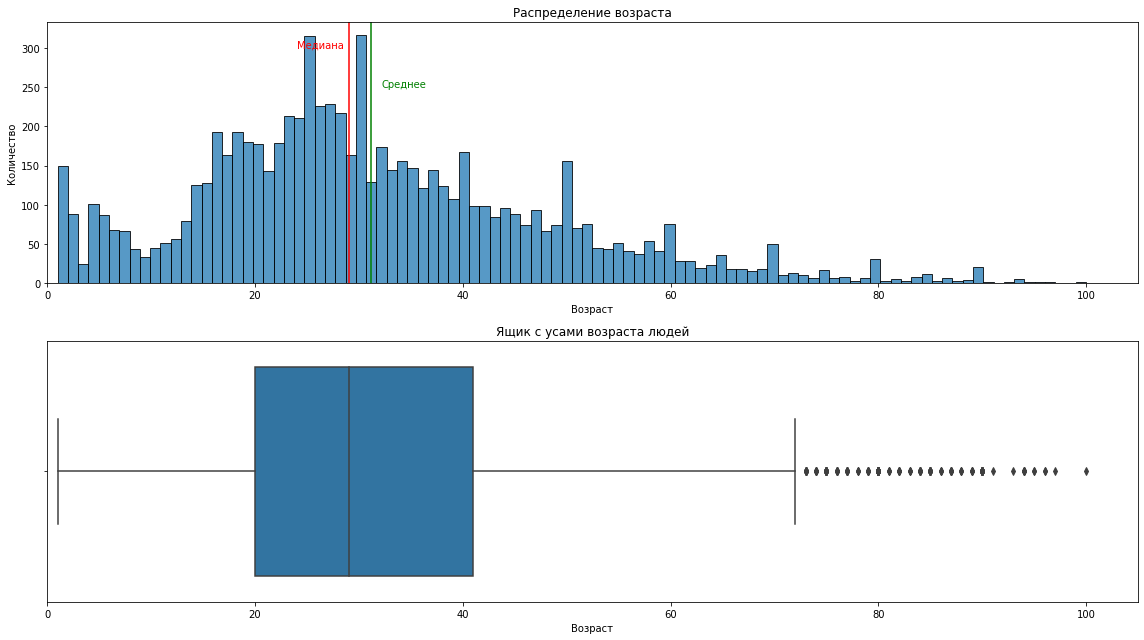

In [6]:
plt.figure(figsize=(16,9))
plt.subplot(2,1,1)
sns.histplot(data=df, x='real_age', bins=100)
plt.axvline(df['real_age'].median(), color='r')
plt.text(df['real_age'].median() - 5, 300, "Медиана", color='r')
plt.axvline(df['real_age'].mean(), color='g')
plt.text(df['real_age'].mean() + 1, 250, "Среднее", color='g')
plt.xlim(0)
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.subplot(2,1,2)
sns.boxplot(data=df, x='real_age')
plt.xlim(0)
plt.xlabel('Возраст')
plt.title('Ящик с усами возраста людей')
plt.tight_layout();

Исходя из полученного графика, можно сделать вывод, что модель будет хуже определять людей с возрастом выше 80 и около 10 лет, из-за меньшего количество фотографий. Есть локальные пики на 1, 25, 30, 40, 50, 60, 70, 80 годах

In [7]:
df.pivot_table(index='real_age', values='file_name', aggfunc='count').sort_values(by='file_name', ascending=False).head(10)

,file_name
real_age,
30,317
25,315
27,229
26,226
28,217
23,213
24,211
16,193
18,193


Больше всего фотографий людей от 23 до 30 лет

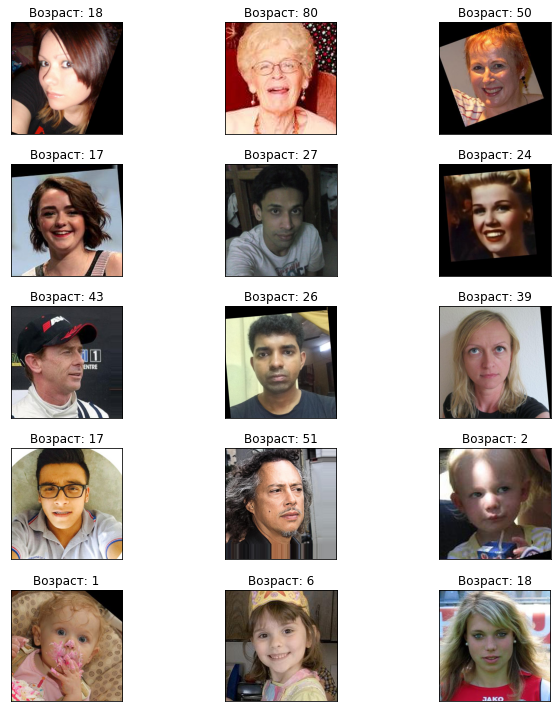

In [8]:
_, axs = plt.subplots(5,3, figsize=(10,10))
s = 0
for i in range(5):
    for j in range(3):
        s += 1
        array = np.array([])
        ax = axs[i,j]
        file_name = df['file_name'][s]
        image = Image.open(f'/datasets/faces/final_files/{file_name}')
        array = np.array(image)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(array)
        ax.set_title(f'Возраст: {df["real_age"][s]}')
plt.tight_layout()

**Промежуточные итоги**
- В датасете приведы фотографии людей в количестве 7591
- Возрастной промежуток от 1 года до 100 лет, с локальными пиками на 1, 25, 30, 40, 50, 60, 70, 80 годах, больше всего фотографий людей возрастом от 23 до 30 лет
- Как можно заметить уже была проведена обработка фотографий
- Присутствуют черные и белые артефакты связанные с обрезкой фотографий
- Также есть лишние объекты в кадре, которые могут повлиять на обучение нейросети

## Обучение модели

Код обучения модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.applications.resnet50 import preprocess_input


def load_train(path):
    labels = pd.read_csv(f'{path}/labels.csv')

    datagen = ImageDataGenerator(
        rescale=1 / 255.,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[0.8, 1.2],
        channel_shift_range=0.1,
        #preprocessing_function=preprocess_input,
        validation_split=0.2
        
    )

    train_gen = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training'
    )

    return train_gen


def load_test(path):
    labels = pd.read_csv(f'{path}/labels.csv')

    datagen = ImageDataGenerator(rescale=1 / 255., validation_split=0.2)
    test_gen = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation'
    )

    return test_gen


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        #weights='imagenet', 
                        include_top=False)

    model = Sequential()
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer_adam = Adam(lr=.00001)
    model.compile(optimizer=optimizer_adam, 
                  loss='mse', 
                  metrics=['mae'])

    model.summary()
    
    return model


def train_model(model,
                train_data, 
                test_data, 
                batch_size=None, epochs=15, 
                steps_per_epoch=None, 
                validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data, 
              batch_size=batch_size, 
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model


```

**Вывод значений из консоли при обучении и валидации модели**

```

Train for 190 steps, validate for 48 steps
Epoch 1/15
190/190 - 140s - loss: 791.2726 - mae: 23.4844 - val_loss: 1142.1924 - val_mae: 29.3182
Epoch 2/15
190/190 - 143s - loss: 250.0143 - mae: 12.2267 - val_loss: 1142.0966 - val_mae: 29.3171
Epoch 3/15
190/190 - 142s - loss: 144.3149 - mae: 9.0067 - val_loss: 721.0450 - val_mae: 21.4957
Epoch 4/15
190/190 - 135s - loss: 112.2599 - mae: 7.9601 - val_loss: 141.5392 - val_mae: 8.9146
Epoch 5/15
190/190 - 142s - loss: 102.3596 - mae: 7.6666 - val_loss: 95.8586 - val_mae: 7.3085
Epoch 6/15
190/190 - 147s - loss: 92.0202 - mae: 7.2677 - val_loss: 81.0395 - val_mae: 6.7081
Epoch 7/15
190/190 - 146s - loss: 85.8073 - mae: 7.0338 - val_loss: 82.4254 - val_mae: 6.7902
Epoch 8/15
190/190 - 141s - loss: 80.0714 - mae: 6.8257 - val_loss: 80.7955 - val_mae: 6.7823
Epoch 9/15
190/190 - 145s - loss: 75.5276 - mae: 6.6247 - val_loss: 81.1580 - val_mae: 6.7816
Epoch 10/15
190/190 - 142s - loss: 70.4155 - mae: 6.4318 - val_loss: 90.7887 - val_mae: 7.2388
Epoch 11/15
190/190 - 146s - loss: 68.2788 - mae: 6.3152 - val_loss: 76.8100 - val_mae: 6.5538
Epoch 12/15
190/190 - 142s - loss: 65.9603 - mae: 6.2237 - val_loss: 76.2187 - val_mae: 6.5282
Epoch 13/15
190/190 - 130s - loss: 63.6236 - mae: 6.0989 - val_loss: 78.8116 - val_mae: 6.6610
Epoch 14/15
190/190 - 130s - loss: 60.1027 - mae: 5.9366 - val_loss: 77.9588 - val_mae: 6.6699
Epoch 15/15
190/190 - 129s - loss: 58.2093 - mae: 5.8598 - val_loss: 80.9008 - val_mae: 6.7624

48/48 - 8s - loss: 80.9008 - mae: 6.7624
```

**Промежуточные итоги**
- Была обучена нейросеть на основе ResNet50
- На 15 эпохах была достигнута метрика MAE=6.76, что является хорошим результатом

## Анализ обученной модели

- Была обучена нейросеть для определения возраста, на основе ResNet50. 
- Были загруженные предобученные веса 
- Оптимизатор - Adam, learning_rate = 0.00001
- Заморозка не требуется из-за размера датасета в 7956 строк (фотографий)
- Нейронная сеть была обучена на 15 эпохах с размером батчей в 32 (по умолчанию)
- Разница метрик небольшая при обучении и валидации, поэтому, можно сказать, что переобучения нет
- **Была получена метрика MAE=6.76.**

Фотофиксация в прикассовой зоне для определения возраста клиента:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы. Нейросеть решает эту проблему из-за рамок возрастных групп около 12-15 лет
- Контролировать добросовестность кассиров при продаже алкоголя. Нейросеть не справится с поставленной задачей из-за разброса больше 6 лет

Можно достигнуть лучшего результата, более гипкой настройкой модели, помимо этого стоит обратить внимание на распределение возраста в датасете, из-за разброса она будет хуже определять людей возрастом ниже 20 и выше 60. Также стоит убрать фотографии детей до 10 лет, поскольку присутствует пик на 1 году, который для нашей задачи не требуется